In [1]:
%reset
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import fooof
from fooof import FOOOF

import numpy as np
import pandas as pd
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 6
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

import os
import warnings
warnings.filterwarnings('ignore')

import mne
from mne import io

def data_eeg(chandat, srate):
    # make the PSD
    window_size = int(srate*10)
    overlap = int(window_size * 0.5)

    xf, _, psd_array = signal.spectrogram(chandat, fs=srate, window=('hanning'), nperseg=window_size, noverlap=overlap)
    psd_array = psd_array.astype('float64')
    psd_array = np.nanmean(psd_array,1)
    psd_array = np.log10(psd_array)

    return psd_array, xf


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
Events like the following will be dropped entirely: ['boundary'], 1 in total
8/1927 event codes could not be mapped to integers. Use the 'event_id' parameter to map such events manually.
Reading eegwm/15-LH.fdt
(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(6, 3)
(7, 3)
(8, 3)
(9, 3)
(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 3)
(6, 3)
(7, 3)
(8, 3)
(9, 3)

                                          FOOOF - PSD MODEL                                          

                     The input PSD was modelled in the frequency range 1-40 Hz                      
                                 Frequency Resolution is 0.10 Hz 
                                  
                                      Background Parameters:                                        
                                     -6.6731, -3.6834, 5.54e-23                                     

                         

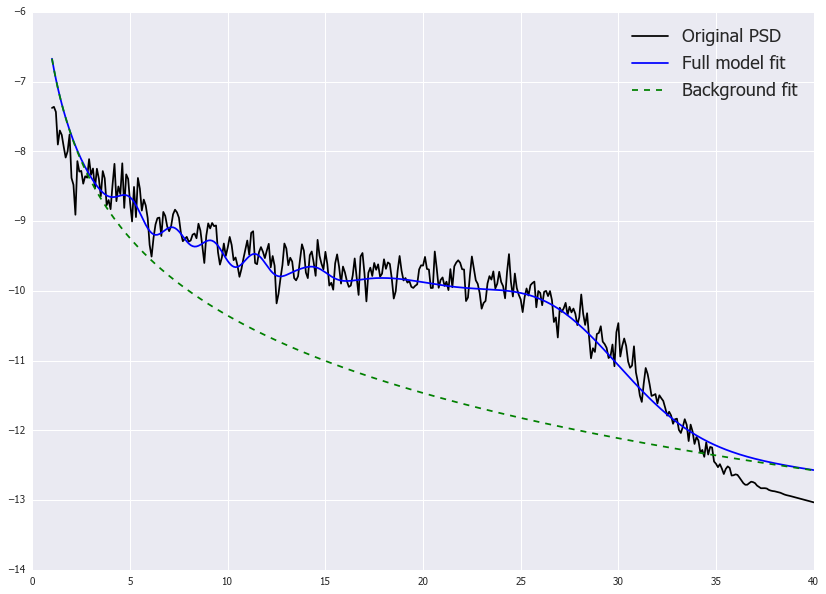

In [3]:
fname = 'eegwm/15-LH.set'

raw = io.read_raw_eeglab(fname)

data, times = raw[0:64, :]
srate = raw.info['sfreq']

chan_i = 38
psd_array, freqs = data_eeg(data[chan_i,:], srate)
ff = FOOOF()
f_range = [1, 40]
ff.fit(freqs, psd_array, f_range)
ff.model(freqs, psd_array, f_range)

In [ ]:
col_file = []
col_chan = []
col_cf = []
col_amp = []
col_bw = []
col_offset = []
col_slope = []
col_curve = []

eeg_chans = range(0,64)
f_range = [1, 40]

my_dir = '/Users/Voytek/fooof/eegwm'
for file in os.listdir(my_dir):
    if file.endswith('.set'):
        filename = os.path.join(my_dir, file)
        
        raw = io.read_raw_eeglab(filename)

        data, times = raw[eeg_chans, :]
        srate = raw.info['sfreq']

        for chan_i in range(np.shape(data)[0]):
            psd_array, freqs = data_eeg(data[chan_i,:], srate)

            ff = FOOOF()
            ff.fit(freqs, psd_array, f_range)
            oscillation_params = ff.oscillation_params
            background_params = ff.background_params

            if np.any(oscillation_params):
                for i in range(np.shape(oscillation_params)[0]):
                    col_cf.append(oscillation_params[i][0])
                    col_amp.append(oscillation_params[i][1])
                    col_bw.append(oscillation_params[i][2])
                    col_offset.append(background_params[0])
                    col_slope.append(background_params[1])
                    col_curve.append(background_params[2])
                    col_file.append(file)
                    col_chan.append((chan_i + 1))
            else:
                col_cf.append(0)
                col_amp.append(0)
                col_bw.append(0)
                col_offset.append(background_params[0])
                col_slope.append(background_params[1])
                col_curve.append(background_params[2])
                col_file.append(file)
                col_chan.append((chan_i + 1))


In [ ]:
d = {'file': col_file, 'chan': col_chan, 'cf': col_cf, 'amp': col_amp, 'bw': col_bw, 'offset': col_offset, 'slope': col_slope, 'curve': col_curve}
df = pd.DataFrame(data=d)
df = df[['file', 'chan', 'cf', 'amp', 'bw', 'offset', 'slope', 'curve']]
df.to_csv('wm_eeg.csv', sep=',', index = False)

In [ ]:
df = pd.read_csv('wm_eeg.csv')
df = df[df['bw'] > 1.0001]

In [ ]:
plt.scatter(df['bw'], df['amp'])
plt.show()